In [81]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [90]:
with open("OLtest_raw_data_120.txt", "r") as file:
    raw_data = file.read().strip().split("ModeConstantDC")[1:-1]

ndata = len(raw_data)
columns = list(map(lambda x: (x.split(" = ")[0]), raw_data[0].strip().split("\n")))

data_np = np.zeros((len(columns), ndata))
for i in range(ndata):
    data_np[:,i] = list(map(lambda x: float(x.split(" = ")[-1]), raw_data[i].strip().split("\n")))

data = pd.DataFrame(data_np.T, columns=columns)
data.insert(0,"time",np.cumsum(data["dt"]),False)
print(str(data.columns))

Index(['time', 'dt', 'xpos', 'ypos', 'thetapos', 'vfwd', 'omega', 'speed_left',
       'speed_right', 'dc left', 'dc right'],
      dtype='object')


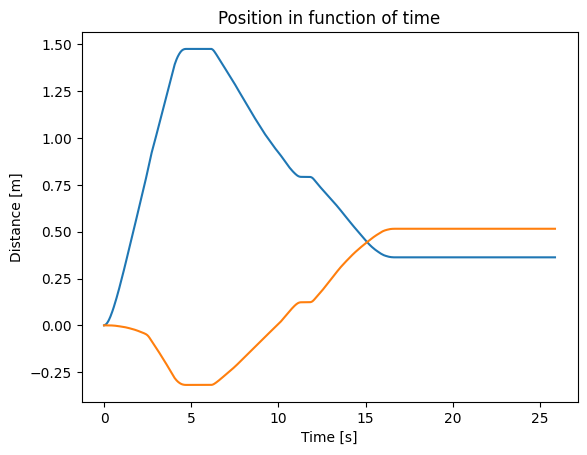

In [91]:
plt.title("Position in function of time")
plt.plot(data["time"], data["xpos"], label="x")
plt.plot(data["time"], data["ypos"], label="y")
plt.xlabel("Time [s]")
plt.ylabel("Distance [m]")
plt.show()

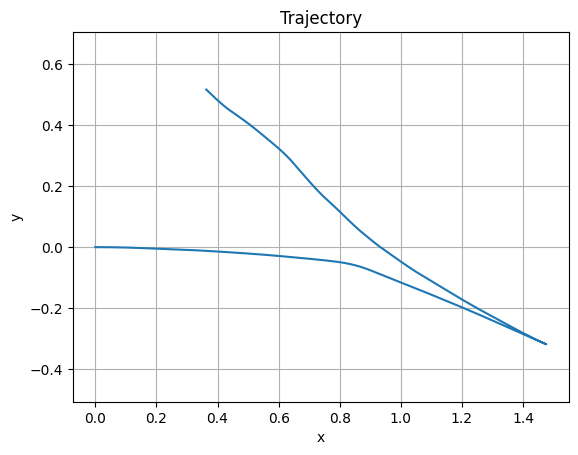

In [92]:
plt.title("Trajectory")
plt.plot(data["xpos"], data["ypos"])
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.grid()
plt.show()

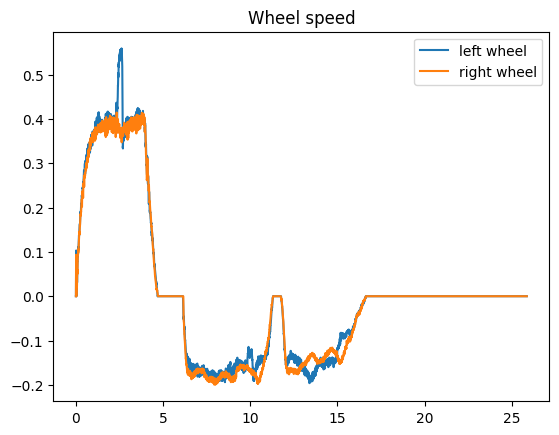

In [94]:
plt.title("Wheel speed")
plt.plot(data["time"], data["speed_left"], label="left wheel")
plt.plot(data["time"], data["speed_right"], label="right wheel")
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


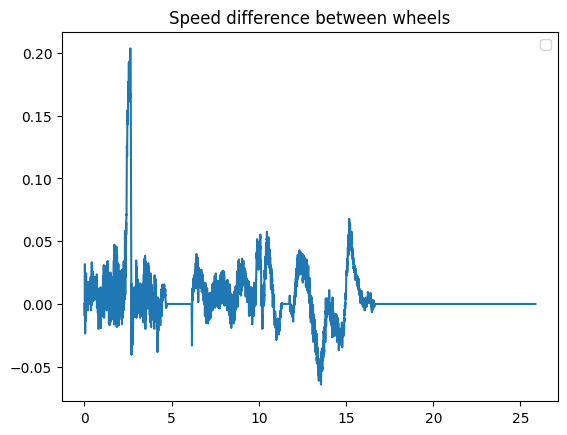

In [96]:
plt.title("Speed difference between wheels")
plt.plot(data["time"], data["speed_left"] - data["speed_right"])
plt.legend()
plt.show()